<a href="https://colab.research.google.com/github/Potdooshami/2H_TaSe2_Tc_STM/blob/main/phasemapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Declare functions

##Main function

In [1]:
import numpy as np

## Divide ##
def z3z3split(phi1,phi2):
  # phi1 from [0,2pi)
  # phi2 from [0,2pi)
  phi1 = phi1%(2*np.pi) # R -> [0,2pi)
  phi2 = phi2%(2*np.pi)
  phi1i = phi1/(2*np.pi) # [0,2pi) -> [0,1)
  phi2i = phi2/(2*np.pi)
  z3z31, rphi1 = divmod(phi1i, 1/3)
  z3z32, rphi2 = divmod(phi2i, 1/3)
  z3z3 = [z3z31,z3z32] # {0,1,2} #len2 list
  rphi12 = [rphi1*3,rphi2*3] # [0,1) #len2 list
  return z3z3,rphi12

def rlsplit(rphi12):
  is_close_10 = rphi12[0]>rphi12[1]#r-like|-> T, g-like|-> F
  if not is_close_10:
    rphi12 = [rphi12[1],rphi12[0]]
  rphi12 = np.array(rphi12)
  rphi12 = rphi12.reshape(2,1) #Basis B
  I_C__B = np.array([[1,-1],[0,1]]) #Identity
  rphi12_C = I_C__B@rphi12 #Basis C
  v_c1 = rphi12_C[0,0]
  v_c2 = rphi12_C[1,0]
  baryHHH_foo = np.array([1-v_c1-v_c2,v_c1,v_c2 ])
  baryHHH_foo = baryHHH_foo.reshape(3,1) #order of index: (00),(??),(11)
  return is_close_10,baryHHH_foo

def sixsplit(baryHHH_foo):
  p_BarHHH = np.sort(baryHHH_foo, axis=0)[::-1]
  z6 = np.argsort(baryHHH_foo, axis=0)[::-1]
  p_AffHHH = p_BarHHH[1:]
  I_AffHAC__AffHHH = np.array([[1,2],[1,-1]])
  p_AffHAC = I_AffHAC__AffHHH@p_AffHHH
  p_BarHAC = np.array([1-p_AffHAC[0]-p_AffHAC[1],p_AffHAC[0],p_AffHAC[1]])
  baryHAC_foo = p_BarHAC
  return z6,baryHAC_foo

## Conquer ##
def get_baryHHH(baryHHH_foo,is_close_10):
  baryHHH = np.zeros(4)
  baryHHH[0] = baryHHH_foo[0,0]
  baryHHH[3] = baryHHH_foo[2,0]
  # print('here',not(is_close_10)+1)
  baryHHH[(not(is_close_10))+1] = baryHHH_foo[1,0]
  return baryHHH #order of index: (00),(10),(01),(11)
def get_baryHAC(is_close_10,baryHAC_foo):
  # baryHAC = np.zeros(3)
  baryHAC = baryHAC_foo
  if not(is_close_10):
    baryHAC = baryHAC_foo[[0,2,1],[0]]
  return baryHAC #order of index: H,10L,01L
def phaseInfo(phi1,phi2):
  z3z3,rphi12 = z3z3split(phi1,phi2)
  is_close_10,baryHHH_foo = rlsplit(rphi12)
  z6,baryHAC_foo = sixsplit(baryHHH_foo)
  baryHHH = get_baryHHH(baryHHH_foo,is_close_10)
  baryHAC = get_baryHAC(is_close_10,baryHAC_foo)
  return baryHHH,baryHAC,z3z3,z6


## Sub function

In [2]:
def phaseInfo2(Phi1,Phi2):
  XY_shape = Phi1.shape
  BaryHHH = np.zeros((XY_shape[0],XY_shape[1],4))
  BaryHAC = np.zeros((XY_shape[0],XY_shape[1],3))
  Z3z3 = np.zeros((XY_shape[0],XY_shape[1],2))
  Z6 = np.zeros((XY_shape[0],XY_shape[1],3))
  for i in range(XY_shape[0]):
    for j in range(XY_shape[1]):
      phi1_now = Phi1[i,j]
      phi2_now = Phi2[i,j]

      baryHHH,baryHAC,z3z3,z6 = phaseInfo(phi1_now,phi2_now)

      BaryHHH[i,j,:] = baryHHH.flatten()
      BaryHAC[i,j,:] = baryHAC.flatten()
      Z3z3[i,j,0] = z3z3[0]
      Z3z3[i,j,1] = z3z3[1]
      Z6[i,j,0] = z6[0]
      Z6[i,j,1] = z6[1]
      Z6[i,j,2] = z6[2]
  return BaryHHH,BaryHAC,Z3z3,Z6

In [3]:
def return_input_and_output(func):
    """
    데코레이터: 함수 호출 시 입력값과 리턴값을 튜플로 묶어 반환합니다.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # 1. 원래 함수를 호출하고 리턴값을 저장합니다.
        result = func(*args, **kwargs)

        # 2. 입력값(*args, **kwargs)과 리턴값(result)을 튜플로 묶어 반환합니다.
        #    입력값은 (위치 인자, 키워드 인자) 형태의 튜플로 구성됩니다.
        return ((args, kwargs), result)
    return wrapper

In [4]:
def generatePhi(lx,ly,resol):
  xx = np.linspace(-lx,lx,lx*resol + 1)
  yy = np.linspace(-ly,ly,ly*resol + 1)
  X,Y = np.meshgrid(xx,yy)
  I_XY__B = np.array([[1,-1/2],[0,np.sqrt(3)/2]])
  I_B__XY = np.linalg.inv(I_XY__B)

  XY_shape = X.shape;
  XY_size = X.size;
  grid_XY =  np.array([X.flatten(),Y.flatten()])
  grid_B = I_B__XY @ grid_XY
  grid_B0 = grid_B[0,:].reshape(XY_shape)
  grid_B1 = grid_B[1,:].reshape(XY_shape)

  Phi = np.stack((grid_B0,grid_B1),axis=2)

  return Phi

In [5]:
def addNoise(Phi,amp,sig):
  import scipy.ndimage
  if amp == 0:
    return Phi
  Phi_dirt = Phi.copy()
  np.random.seed(42)
  shap = Phi.shape
  foo1 = np.random.rand(shap[0],shap[1])
  foo2 = np.random.rand(shap[0],shap[1])

  foo1 = scipy.ndimage.gaussian_filter(foo1, sigma=sig)
  foo2 = scipy.ndimage.gaussian_filter(foo2, sigma=sig)

  foo1 = foo1-.5
  foo2 = foo2-.5

  Phi_dirt[:,:,0] = Phi_dirt[:,:,0] + foo1*amp
  Phi_dirt[:,:,1] = Phi_dirt[:,:,1] + foo2*amp
  return Phi_dirt

In [6]:
def visBasicInfo(Phi,Info):
  import matplotlib.pyplot as plt
  msb,nsb = 4,3
  HHH_holder =Info[0]
  HAC_holder=Info[1]
  z3z3_holder=Info[2]

  fig,axs = plt.subplots(msb,nsb,figsize=(10,10))
  axs[0,1].imshow(HHH_holder[:,:,0], origin='lower')
  axs[1,1].imshow(HHH_holder[:,:,1], origin='lower')
  axs[2,1].imshow(HHH_holder[:,:,2], origin='lower')
  axs[3,1].imshow(HHH_holder[:,:,3], origin='lower')

  axs[0,2].imshow(HAC_holder[:,:,0], origin='lower')
  axs[1,2].imshow(HAC_holder[:,:,1], origin='lower')
  axs[2,2].imshow(HAC_holder[:,:,2], origin='lower')

  axs[0,0].imshow(Phi[:,:,0], origin='lower')
  axs[1,0].imshow(Phi[:,:,1], origin='lower')

  axs[2,0].imshow(z3z3_holder[:,:,0], origin='lower')
  axs[3,0].imshow(z3z3_holder[:,:,1], origin='lower')

  tns = [['phi1','phi2','z3z3_1','z3z3_2'],['00','10','01','11'],['H','L10','L01']]

  for isb in range(msb):
    for jsb in range(nsb):
      axs[isb,jsb].set_xticks([])
      axs[isb,jsb].set_yticks([])
      axs[isb,jsb].plot(250,200,'ro')
      try:
        tn = tns[jsb][isb]
        axs[isb,jsb].set_title(tn)
      except:
        a = 's'


/tmp/ipython-input-3436646536.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z6[i,j,0] = z6[0]
/tmp/ipython-input-3436646536.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z6[i,j,1] = z6[1]
/tmp/ipython-input-3436646536.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z6[i,j,2] = z6[2]


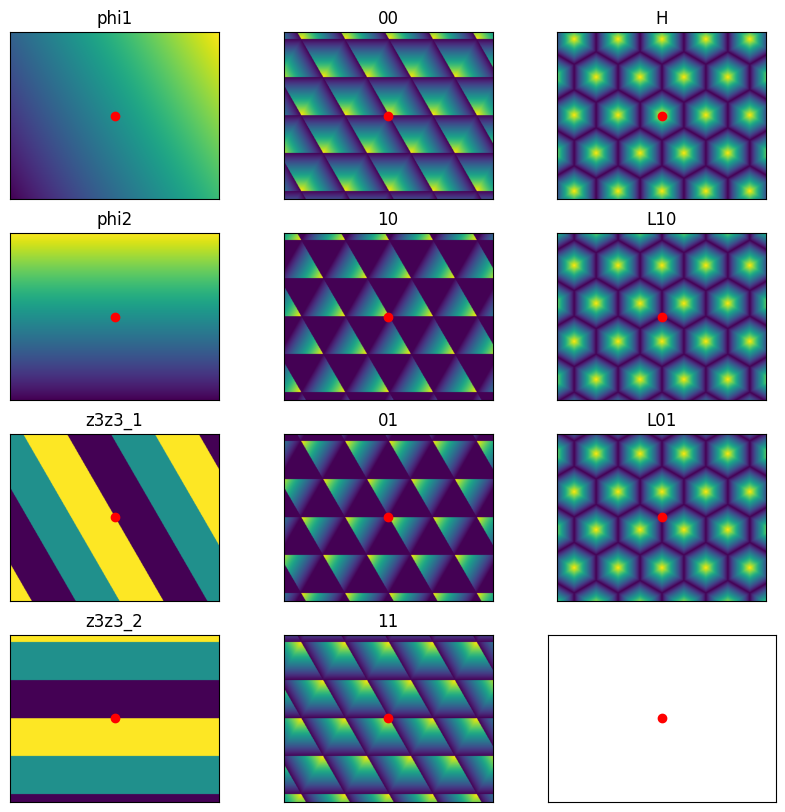

In [7]:
Phi = generatePhi(5,4,100)
Phi = addNoise(Phi,0,5)
Info = phaseInfo2(Phi[:,:,0],Phi[:,:,1])
visBasicInfo(Phi,Info)

# create hac segmentation

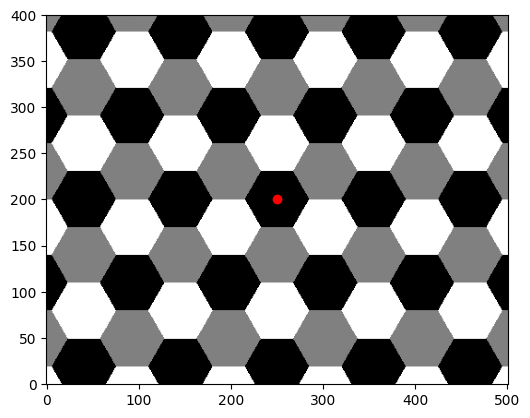

In [8]:
from matplotlib import pyplot as plt

HAC_holder = Info[1]
HAC_argmax = np.argmax(HAC_holder, axis=2)
plt.imshow(HAC_argmax, origin='lower',cmap='gray')

plt.plot(250,200,'ro')




# create HHH phase

In [9]:
def get_z3z3hex(Info):
  HHH_argmax = np.argmax(Info[0], axis=2)
  mod01,mod10 = np.divmod(HHH_argmax ,2)
  hex1 = np.mod(Info[2][:,:,0] + mod10,3)
  hex2 = np.mod(Info[2][:,:,1] + mod01,3)
  z3z3hex = np.stack((hex1,hex2),axis=2)
  return z3z3hex

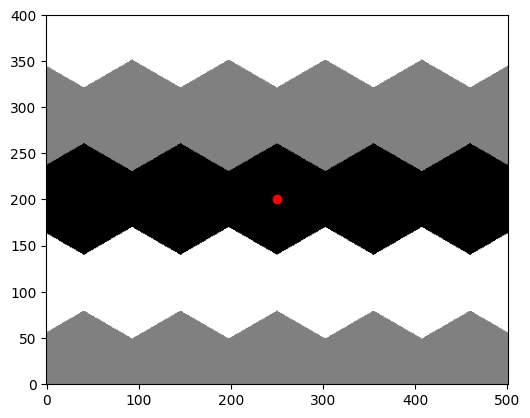

In [10]:
z3z3hex = get_z3z3hex(Info)
plt.imshow(z3z3hex[:,:,1], origin='lower',cmap='gray')
plt.plot(250,200,'ro')

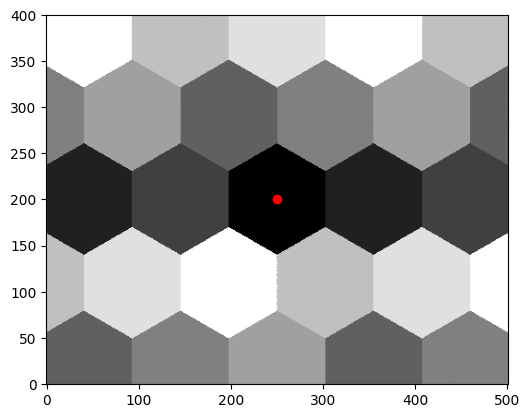

In [11]:
pln = z3z3hex[:,:,0] +z3z3hex[:,:,1]*3
plt.imshow(pln, origin='lower',cmap='gray')
plt.plot(250,200,'ro')

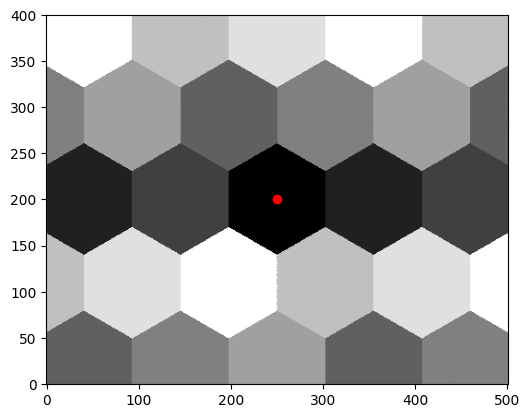

In [12]:
plt.imshow(pln, origin='lower',cmap='gray')
plt.plot(250,200,'ro')

In [54]:
p_00 = [.5,.5,.5]
p_12 = [.1,.1,.1]
p_21 = [.8,.8,.8]

p_10 = [1,0,0]
p_01 = [0,1,0]
p_22 = [0,0,1]

p_20 = [0,1,1]
p_02 = [1,0,1]
p_11 = [1,1,0]

In [55]:
clrset = [[p_00,p_01,p_02],[p_10,p_11,p_12],[p_20,p_21,p_22]]
clrset = np.array(clrset)
clrset.shape


(3, 3, 3)

In [56]:
shp = z3z3hex.shape
phase9 = np.zeros((shp[0],shp[1],3))
for ix  in range(shp[0]):
  for iy in range(shp[1]):
    phase9[ix,iy,:] = clrset[int(z3z3hex[ix,iy,0]),int(z3z3hex[ix,iy,1]),:]

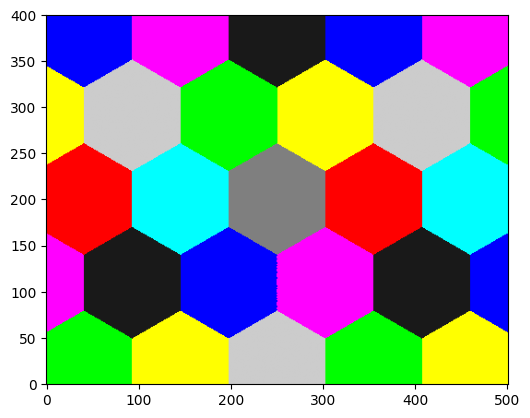

In [57]:
plt.imshow(phase9, origin='lower')

In [50]:
p1 = z3z3hex[1,0,0]
p2 = z3z3hex[1,0,1]
print(p1,p2)
clrset[int(p1),int(p2),:]

0.0 1.0


array([0., 1., 0.])

#Dataprocessing

In [13]:
DWThick = .5
dlt = DWThick

In [14]:
dwBW = Info[1][:,:,0]<DWThick

In [15]:
def getDWsegment(z6,is_close10):
  class6 = [210,201,120,102,21,12]
  blk = [1012,1102,120,210]
  rlk = [1120,1210,12,102]
  glk = [1021,1201,21,201]
  class12 = np.array([blk,rlk,glk])

  class6this = np.sum(z6*np.array([100,10,1]))
  z6 =  class6 == class6this
  class12this = class6this +1000*is_close10
  classified = class12 == class12this
  true_indices = np.where(classified)
  classified3 = true_indices[0][0]
  return classified3

In [16]:
Z6 = Info[3]
Is_close10 = Info[0][:,:,2]>0

# ix,iy= 93,22

classified3s = np.zeros(Z6.shape[0:2])
for ix in range(Z6.shape[0]):
  for iy in range(Z6.shape[1]):
    z6 = Z6[ix,iy,:]# input 1
    is_close10 = Is_close10[ix,iy]# input 2
    classified3 = getDWsegment(z6,is_close10)
    classified3s[ix,iy] = classified3

In [17]:
classified3s_rgb = np.stack((classified3s==1,classified3s==0,classified3s==2),axis=2)

In [18]:
dw_rgb = classified3s_rgb * dwBW[:, :, np.newaxis]

In [19]:
Z3z3,Rphi12 =  z3z3split(Phi[:,:,0],Phi[:,:,1])
coefs = np.array([[-2/4,4/4],[1/2,1/2],[4/4,-2/4]])
# coefs.shape

chiral = np.einsum('ijk,li->jkl', np.array(Rphi12), coefs)
chiral = chiral[:,:,[2,0,1]]
chiral[:,:,2] = -chiral[:,:,2]

In [20]:
chiral[:,:,2].max()

np.float64(-0.0)

##chiral


In [21]:
chiral_ = np.mod(chiral+dlt/2,.5)-dlt/2
chiral_ = -(1/dlt)*(chiral_-dlt/2)
#chiral_[:,:2]=chiral_[:,:2]

In [22]:
final = chiral_*dw_rgb

In [23]:
for ik in range(3):
  foo = final[:,:,ik]
  print(foo.min(),foo.max())


0.0 0.9980842945954058
0.0 0.9999914656866182
0.0 0.9999914656866185


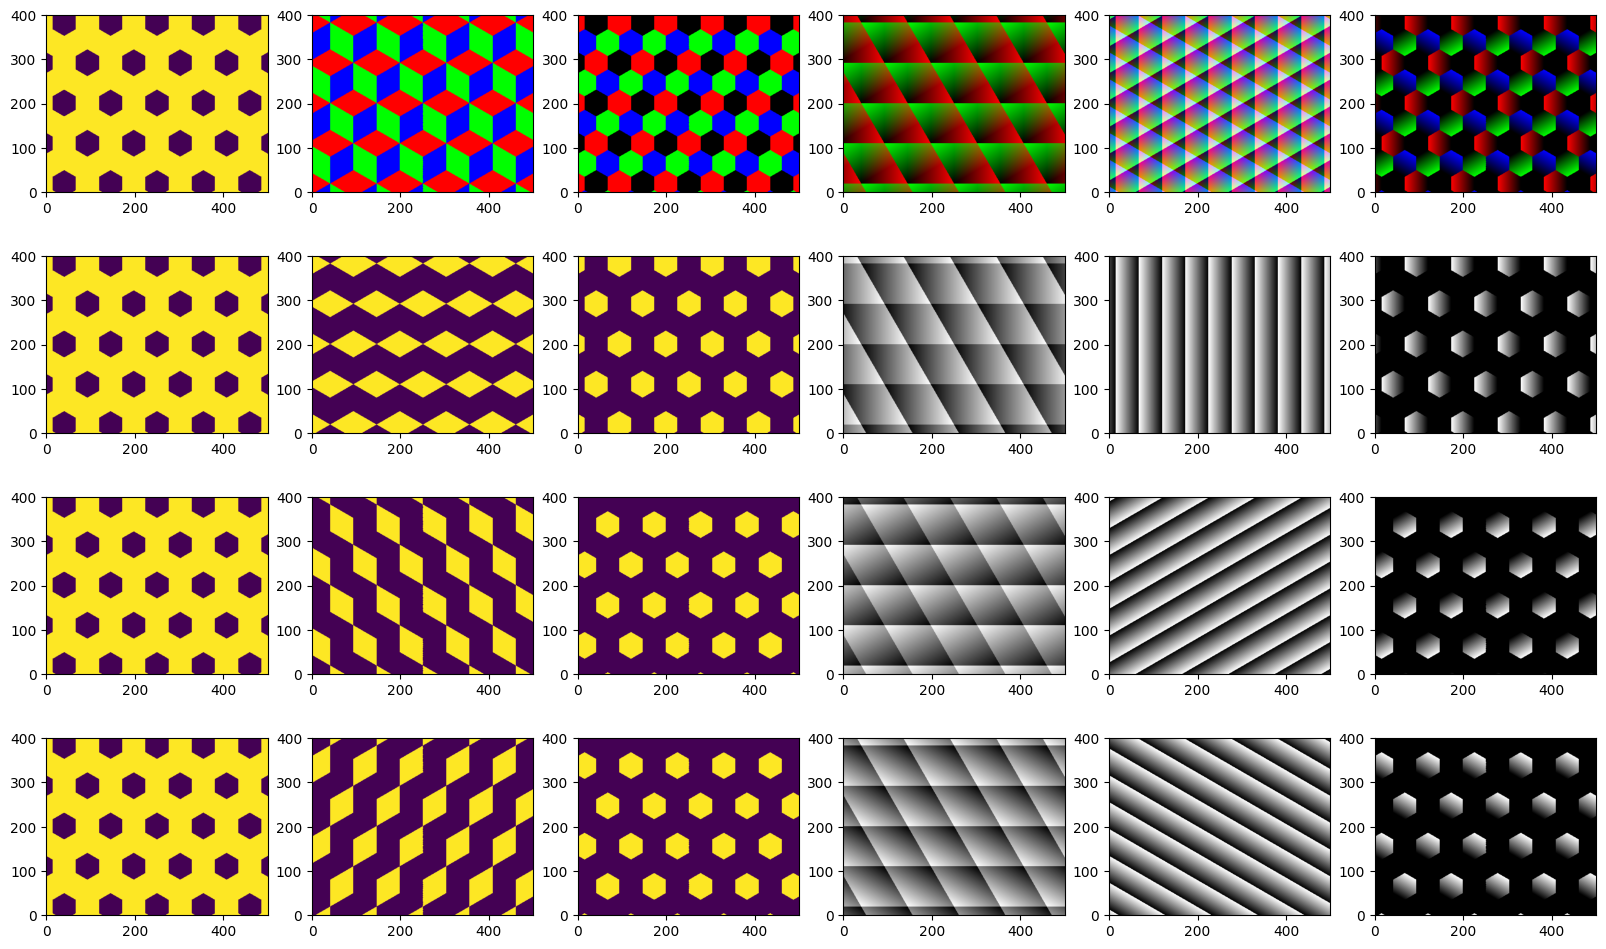

In [24]:
fig,axs = plt.subplots(4,6,figsize=(20,12))
axs[0,0].imshow(dwBW, origin='lower')
axs[0,1].imshow(classified3s_rgb.astype(np.float64), origin='lower')
axs[0,2].imshow(dw_rgb.astype(np.float64), origin='lower')
axs[0,3].imshow(chiral.astype(np.float64), origin='lower')
axs[0,4].imshow(chiral_.astype(np.float64), origin='lower')
axs[0,5].imshow(final.astype(np.float64), origin='lower')
for ik in range(3):
  axs[ik+1,0].imshow(dwBW, origin='lower')
  axs[ik+1,1].imshow(classified3s_rgb[:,:,ik], origin='lower')
  axs[ik+1,2].imshow(dw_rgb[:,:,ik], origin='lower')
  axs[ik+1,3].imshow(chiral[:,:,ik], origin='lower',cmap='gray')
  axs[ik+1,4].imshow(chiral_[:,:,ik], origin='lower',cmap='gray')
  axs[ik+1,5].imshow(final[:,:,ik], origin='lower',cmap='gray')

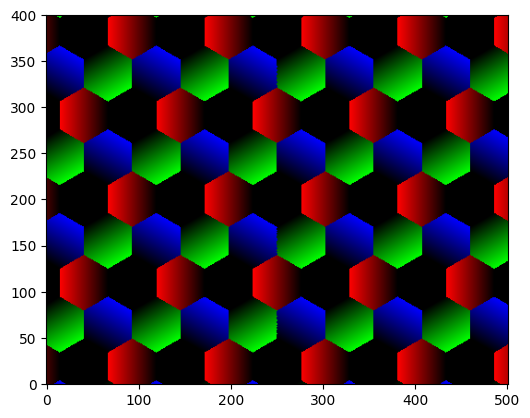

In [25]:
plt.imshow(final.astype(np.float64), origin='lower')

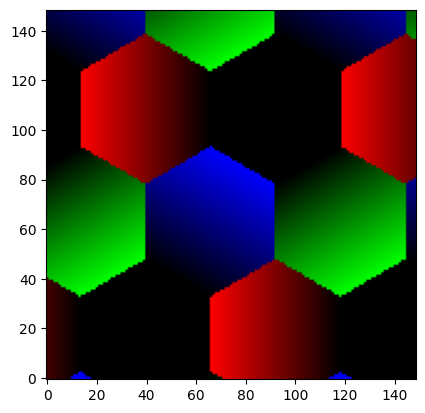

In [26]:
plt.imshow(final[1:150,1:150,:], origin='lower')